<a href="https://colab.research.google.com/github/Igorvl/Projects/blob/master/%D0%A0%D0%B5%D1%88%D0%B5%D0%BD%D0%B8%D0%B5_%D0%B7%D0%B0%D0%B4%D0%B0%D1%87%D0%B8_%D1%80%D0%B5%D0%B3%D1%80%D0%B5%D1%81%D1%81%D0%B8%D0%B8_%D1%81_%D0%BF%D0%BE%D0%BC%D0%BE%D1%89%D1%8C%D1%8E_%D0%BD%D0%B5%D0%B9%D1%80%D0%BE%D0%BD%D0%BD%D1%8B%D1%85_%D1%81%D0%B5%D1%82%D0%B5%D0%B9_%7C_Lite.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Подготовка

In [1]:
# Работа с массивами данных
import numpy as np 

# Работа с табличными данными
import pandas as pd

# Функции-утилиты для работы с категориальными данными
from tensorflow.keras import utils

# Класс для конструирования последовательной модели нейронной сети
from tensorflow.keras.models import Sequential, Model

# Основные слои
from tensorflow.keras.layers import Dense, Dropout, SpatialDropout1D, BatchNormalization, Embedding, Flatten, Activation, Input, concatenate
from tensorflow.keras.layers import SimpleRNN, GRU, LSTM, Bidirectional, Conv1D, MaxPooling1D, GlobalMaxPooling1D

# Оптимизаторы
from tensorflow.keras.optimizers import Adam, Adadelta, SGD, Adagrad, RMSprop

# Токенизатор для преобразование текстов в последовательности
from tensorflow.keras.preprocessing.text import Tokenizer

# Масштабирование данных
from sklearn.preprocessing import StandardScaler

# Загрузка датасетов из облака google
import gdown

# Регулярные выражения
import re

# Отрисовка графиков
import matplotlib.pyplot as plt

# Метрики для расчета ошибок
from sklearn.metrics import mean_squared_error, mean_absolute_error

%matplotlib inline

In [2]:
# скачиваем базу
gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l10/hh_fixed.csv', None, quiet=True)

# Чтение файла базы данных
df = pd.read_csv('hh_fixed.csv', index_col=0)

# Вывод количества резюме и числа признаков
print(df.shape)

df.head(3)

(62967, 12)


,"Пол, возраст",ЗП,Ищет работу на должность:,Город,Занятость,График,Опыт (двойное нажатие для полной версии),Последенее/нынешнее место работы,Последеняя/нынешняя должность,Образование и ВУЗ,Обновление резюме,Авто
0,"Мужчина , 29 лет , родился 16 мая 1989",40000 руб.,Специалист по поддержке чата(support team) дом...,"Новороссийск , готов к переезду (Анапа, Геленд...",полная занятость,полный день,Опыт работы 3 года 9 месяцев Специалист по по...,"ООО ""Гольфстрим""",Генеральный директор,Высшее образование 2011 Международный юридиче...,26.04.2019 08:04,Не указано
1,"Мужчина , 38 лет , родился 25 мая 1980",40000 руб.,Системный администратор,"Новосибирск , м. Березовая роща , не готов к ...",полная занятость,полный день,Опыт работы 11 лет 11 месяцев Системный админ...,ООО «Завод модульных технологий»,Системный администратор,Высшее образование 2002 Новосибирский государс...,26.04.2019 04:30,Не указано
2,"Мужчина , 35 лет , родился 14 июня 1983",300000 руб.,DevOps TeamLead / DevOps архитектор,"Москва , готов к переезду , готов к редким ком...",полная занятость,полный день,Опыт работы 12 лет 11 месяцев DevOps TeamLead...,Банк ВТБ (ПАО),Начальник отдела методологии разработки (DevOp...,DevOps TeamLead / DevOps архитектор 300 000 ру...,09.04.2019 14:40,Не указано


In [3]:
# Настройка номеров столбцов

COL_SEX_AGE     = df.columns.get_loc('Пол, возраст')
COL_SALARY      = df.columns.get_loc('ЗП')
COL_POS_SEEK    = df.columns.get_loc('Ищет работу на должность:')
COL_POS_PREV    = df.columns.get_loc('Последеняя/нынешняя должность')
COL_CITY        = df.columns.get_loc('Город')
COL_EMPL        = df.columns.get_loc('Занятость')
COL_SCHED       = df.columns.get_loc('График')
COL_EXP         = df.columns.get_loc('Опыт (двойное нажатие для полной версии)')
COL_EDU         = df.columns.get_loc('Образование и ВУЗ')
COL_UPDATED     = df.columns.get_loc('Обновление резюме')

In [4]:
# Замена концов строк на пробелы, удаление символа с кодом 0xA0
# обрезка краевых пробелов, приведение к нижнему регистру

def purify(x):
    if isinstance(x, str):                # Если значение - строка:
        x = x.replace('\n', ' ').replace('\xa0', '').strip().lower()
    return x

In [5]:
# Выделение подстроки вида ДД.ММ.ГГГГ и возвращение значения года

def extract_year(x):
    try: 
        return int(re.search(r'\d\d.\d\d.(\d{4})', x)[1])   # Ожидается строка вида 'dd.mm.yyyy ...'
  
    except (IndexError, TypeError, ValueError):
        return 0     

In [6]:
### Параметрические данные для функций разбора ###

# Курсы валют для зарплат
currency_rate = {'usd'    : 65.,
                 'kzt'    : 0.17,
                 'грн'    : 2.6,
                 'белруб' : 30.5,
                 'eur'    : 70.,
                 'kgs'    : 0.9,
                 'сум'    : 0.007,
                 'azn'    : 37.5
                }

# Списки и словари для разбиения на классы
# Для ускорения работы добавлен счетчик классов, который будет вычислен ниже

# Список порогов возраста
age_class = [0, [18, 23, 28, 33, 38, 43, 48, 53, 58, 63]]

# Список порогов опыта работы в месяцах
experience_class = [0, [7, 13, 25, 37, 61, 97, 121, 157, 193, 241]]

# Классы городов
city_class = [0, 
              {'москва'          : 0,
               'санкт-петербург' : 1,
               'новосибирск'     : 2,
               'екатеринбург'    : 2,
               'нижний новгород' : 2,
               'казань'          : 2,
               'челябинск'       : 2,
               'омск'            : 2,
               'самара'          : 2,
               'ростов-на-дону'  : 2,
               'уфа'             : 2,
               'красноярск'      : 2,
               'пермь'           : 2,
               'воронеж'         : 2,
               'волгоград'       : 2,
               'прочие города'   : 3
              }]

# Классы занятости
employment_class = [0, 
                    {'стажировка'          : 0,
                     'частичная занятость' : 1,
                     'проектная работа'    : 2,
                     'полная занятость'    : 3
                    }]

# Классы графика работы
schedule_class = [0, 
                  {'гибкий график'         : 0,
                   'полный день'           : 1,
                   'сменный график'        : 2,
                   'удаленная работа'      : 3
                  }]

# Классы образования
education_class = [0,
                   {'высшее образование'   : 0,
                    'higher education'     : 0,
                    'среднее специальное'  : 1,
                    'неоконченное высшее'  : 2,
                    'среднее образование'  : 3
                   }]


In [7]:
# Вычисление счетчиков для данных разбиения

for class_desc in [age_class,
                   experience_class,
                   city_class,
                   employment_class,
                   schedule_class,
                   education_class]:
    if isinstance(class_desc[1], list):
        class_desc[0] = len(class_desc[1]) + 1
    else:
        class_desc[0] = max(class_desc[1].values()) + 1

In [8]:
 # Получение one hot encoding представления значения класса
 
def int_to_ohe(arg, class_list):
  
    # Определение размерности выходного вектора
    num_classes = class_list[0]

    # Поиск верного интервала для входного значения
    for i in range(num_classes - 1):
        if arg < class_list[1][i]:
            cls = i                       # Интервал найден - назначение класса
            break
    else:                                 # Внимание: for/else
        cls = num_classes - 1             # Интервал не найден - последний класс

    # Возврат в виде one hot encoding-вектора
    return utils.to_categorical(cls, num_classes)

In [9]:
# Общая функция преобразования строки к multi-вектору
# На входе данные и словарь сопоставления подстрок классам

def str_to_multi(arg, class_dict):
    # Определение размерности выходного вектора
    num_classes = class_dict[0]

    # Создание нулевого вектора
    result = np.zeros(num_classes)
    
    # Поиск значения в словаре и, если найдено,
    # выставление 1. на нужной позиции
    for value, cls in class_dict[1].items():
        if value in arg:
            result[cls] = 1.

    return result

In [10]:
# Разбор значений пола, возраста

base_update_year = 2019

def extract_sex_age_years(arg):
    # Ожидается, что значение содержит "мужчина" или "женщина"
    # Если "мужчина" - результат 1., иначе 0.
    sex = 1. if 'муж' in arg else 0.

    try:
        # Выделение года и вычисление возраста
        years = base_update_year - int(re.search(r'\d{4}', arg)[0])

    except (IndexError, TypeError, ValueError):
        # В случае ошибки год равен 0
        years = 0

    return sex, years

In [11]:
# Преобразование значения возраста в one hot encoding

def age_years_to_ohe(arg):
    return int_to_ohe(arg, age_class)

In [12]:
# Преобразование данных об опыте работы в one hot encoding

def experience_months_to_ohe(arg):
    return int_to_ohe(arg, experience_class)

In [13]:
# Разбор значения зарплаты

def extract_salary(arg):
    try:
        # Выделение числа и преобразование к float
        value = float(re.search(r'\d+', arg)[0])

        # Поиск символа валюты в строке, и, если найдено,
        # приведение к рублю по курсу валюты
        for currency, rate in currency_rate.items():
            if currency in arg:
                value *= rate
                break

    except TypeError:
        # Если не получилось выделить число - вернуть 0
        value = 0.

    return value / 1000.                  # В тысячах рублей

In [14]:
# Разбор данных о городe и преобразование в one hot encoding

def extract_city_to_ohe(arg):
    # Определение размерности выходного вектора
    num_classes = city_class[0]

    # Разбивка на слова
    split_array = re.split(r'[ ,.:()?!]', arg)

    # Поиск города в строке и присвоение ему класса
    for word in split_array:
        city_cls = city_class[1].get(word, -1)
        if city_cls >= 0:
            break
    else:                                 # Внимание: for/else
        # Город не в city_class - значит его класс "прочие города"
        city_cls = num_classes - 1

    # Возврат в виде one hot encoding-вектора
    return utils.to_categorical(city_cls, num_classes)

In [15]:
# Разбор данных о желаемой занятости и преобразование в multi

def extract_employment_to_multi(arg):
    return str_to_multi(arg, employment_class)

In [16]:
# Разбор данных о желаемом графике работы и преобразование в multi

def extract_schedule_to_multi(arg):
    return str_to_multi(arg, schedule_class)

In [17]:
# Разбор данных об образовании и преобразование в multi

def extract_education_to_multi(arg):
    result = str_to_multi(arg, education_class)
    
    # Поправка: неоконченное высшее не может быть одновременно с высшим
    if result[2] > 0.:
        result[0] = 0.
    
    return result

In [18]:
# Разбор данных об опыте работы - результат в месяцах

def extract_experience_months(arg):
    try:
        # Выделение количества лет, преобразование в int
        years = int(re.search(r'(\d+)\s+(год.?|лет)', arg)[1])

    except (IndexError, TypeError, ValueError):
        # Неудача - количество лет равно 0
        years = 0
    
    try:
        # Выделение количества месяцев, преобразование в int
        months = int(re.search(r'(\d+)\s+месяц', arg)[1])

    except (IndexError, TypeError, ValueError):
        # Неудача - количество месяцев равно 0
        months = 0

    # Возврат результата в месяцах
    return years * 12 + months

Функции подготовки выборок

In [19]:
def extract_row_data(row):
  
    # Извлечение и преобразование данных
    sex, age = extract_sex_age_years(row[COL_SEX_AGE])      # Пол, возраст
    sex_vec = np.array([sex])                               # Пол в виде вектора
    age_ohe = age_years_to_ohe(age)                         # Возраст в one hot encoding
    city_ohe = extract_city_to_ohe(row[COL_CITY])           # Город
    empl_multi = extract_employment_to_multi(row[COL_EMPL]) # Тип занятости
    sсhed_multi = extract_schedule_to_multi(row[COL_SCHED]) # График работы
    edu_multi = extract_education_to_multi(row[COL_EDU])    # Образование
    exp_months = extract_experience_months(row[COL_EXP])    # Опыт работы в месяцах
    exp_ohe = experience_months_to_ohe(exp_months)          # Опыт работы в one hot encoding
    salary = extract_salary(row[COL_SALARY])                # Зарплата в тысячах рублей
    salary_vec = np.array([salary])                         # Зарплата в виде вектора

    # Объединение всех входных данных в один общий вектор
    x_data = np.hstack([sex_vec,
                        age_ohe, 
                        city_ohe,
                        empl_multi,
                        sсhed_multi,
                        edu_multi,
                        exp_ohe])
    
    # Возврат входных данных и выходных (зарплаты)
    return x_data, salary_vec


# Создание общей выборки
def construct_train_data(row_list):
    x_data = []
    y_data = []
    
    for row in row_list:
        x, y = extract_row_data(row)
        if y[0] > 0:                      # Данные добавляются, только если есть зарплата
            x_data.append(x)
            y_data.append(y)

    return np.array(x_data), np.array(y_data)

In [20]:
# Формирование выборки из загруженного набора данных    
x_train_01, y_train = construct_train_data(df.values)

In [21]:
# Форма наборов параметров и зарплат
print(x_train_01.shape) 
print(y_train.shape)

# Пример обработанных данных
n = 0 
print(x_train_01[n])
print(y_train[n])

(62967, 39)
(62967, 1)
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[40.]


Функция отрисовки графика истории обучения

In [22]:
def plot_history(history):
    plt.plot(history.history['mae'], 
            label='Средняя абсолютная ошибка на обучающем наборе')
    plt.plot(history.history['val_mae'], 
            label='Средняя абсолютная ошибка на проверочном наборе')
    plt.xlabel('Эпоха обучения')
    plt.ylabel('Средняя абсолютная ошибка')
    plt.legend()
    plt.show()

На основе подготовленной для нейросети таблицы данных с HeadHunter создайте 6 архитектур нейросетей, поэкспериментируйте с гиперпараметрами.
Используйте только числовые данные, текстовые не подавайте.

Результаты в конце проанализируйте.


Epoch 1/35
331/419 [======================>.......] - ETA: 0s - loss: 7410.8843 - mae: 54.3307

Exception ignored in: <function WeakKeyDictionary.__init__.<locals>.remove at 0x7f1bde8b7160>
Traceback (most recent call last):
  File "/usr/lib/python3.8/weakref.py", line 345, in remove
    def remove(k, selfref=ref(self)):
KeyboardInterrupt: 


419/419 [==============================] - 5s 8ms/step - loss: 6769.7583 - mae: 52.2279 - val_loss: 5240.0444 - val_mae: 44.5501
Epoch 2/35
419/419 [==============================] - 3s 7ms/step - loss: 4753.6343 - mae: 43.4142 - val_loss: 5070.9839 - val_mae: 43.9640
Epoch 3/35
419/419 [==============================] - 3s 6ms/step - loss: 4653.8716 - mae: 42.5298 - val_loss: 4983.2842 - val_mae: 44.5116
Epoch 4/35
419/419 [==============================] - 3s 7ms/step - loss: 4604.3438 - mae: 42.2061 - val_loss: 4952.2466 - val_mae: 44.0170
Epoch 5/35
419/419 [==============================] - 3s 6ms/step - loss: 4580.8784 - mae: 42.0203 - val_loss: 4931.7598 - val_mae: 43.7859
Epoch 6/35
419/419 [==============================] - 3s 6ms/step - loss: 4564.5688 - mae: 41.9724 - val_loss: 4921.5840 - val_mae: 43.4212
Epoch 7/35
419/419 [==============================] - 3s 6ms/step - loss: 4552.8438 - mae: 41.8427 - val_loss: 4915.4878 - val_mae: 43.1857
Epoch 8/35
419/419 [===========

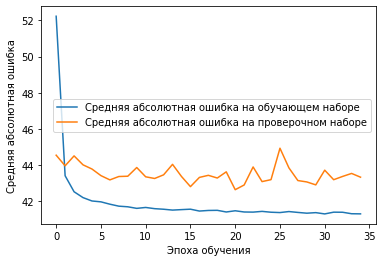

In [27]:
# Ваше решение

model = Sequential()
model.add(BatchNormalization(input_dim = x_train_01.shape[1]))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(1024, activation = 'tanh'))
model.add(Dense(32, activation = 'relu'))
model.add(Dense(1, activation = 'linear'))

model.compile(optimizer = Adam(learning_rate=0.0001), loss = 'mse', metrics = ['mae'])
hist = model.fit(x_train_01, y_train, epochs=35, batch_size = 128, validation_split = 0.15, verbose = 1)
plot_history(hist)

Epoch 1/35
419/419 [==============================] - 5s 9ms/step - loss: 8218.1582 - mae: 60.7257 - val_loss: 6607.4839 - val_mae: 50.6899
Epoch 2/35
419/419 [==============================] - 4s 8ms/step - loss: 5297.1973 - mae: 45.8285 - val_loss: 5280.7051 - val_mae: 45.2104
Epoch 3/35
419/419 [==============================] - 5s 11ms/step - loss: 4889.7930 - mae: 43.3732 - val_loss: 5057.0469 - val_mae: 43.7011
Epoch 4/35
419/419 [==============================] - 4s 10ms/step - loss: 4729.7271 - mae: 42.3619 - val_loss: 4982.8096 - val_mae: 43.5220
Epoch 5/35
419/419 [==============================] - 4s 11ms/step - loss: 4667.1211 - mae: 42.1762 - val_loss: 4956.3936 - val_mae: 43.1121
Epoch 6/35
419/419 [==============================] - 6s 14ms/step - loss: 4638.9834 - mae: 42.0802 - val_loss: 4923.1831 - val_mae: 43.3958
Epoch 7/35
419/419 [==============================] - 4s 9ms/step - loss: 4617.0347 - mae: 41.9777 - val_loss: 4908.8276 - val_mae: 43.4869
Epoch 8/35
419/4

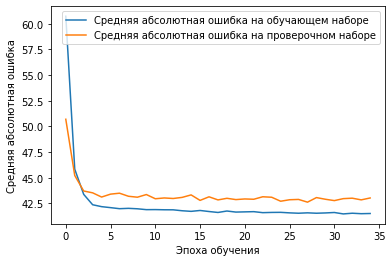

In [28]:
# Вариант №2 добавлена нормализация

model = Sequential()
model.add(BatchNormalization(input_dim = x_train_01.shape[1]))
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.25))
model.add(Dense(1024, activation = 'tanh'))
model.add(BatchNormalization())
model.add(Dense(32, activation = 'relu'))
model.add(Dense(1, activation = 'linear'))

model.compile(optimizer = Adam(learning_rate=0.0001), loss = 'mse', metrics = ['mae'])
hist = model.fit(x_train_01, y_train, epochs=35, batch_size = 128, validation_split = 0.15, verbose = 1)
plot_history(hist)

Epoch 1/35
419/419 [==============================] - 13s 29ms/step - loss: 6132.5112 - mae: 49.3256 - val_loss: 5721.9771 - val_mae: 43.9985
Epoch 2/35
419/419 [==============================] - 12s 28ms/step - loss: 4712.0244 - mae: 42.6286 - val_loss: 4988.2476 - val_mae: 43.2566
Epoch 3/35
419/419 [==============================] - 14s 33ms/step - loss: 4642.0308 - mae: 42.1538 - val_loss: 4934.2188 - val_mae: 43.6722
Epoch 4/35
419/419 [==============================] - 18s 43ms/step - loss: 4608.3262 - mae: 42.0874 - val_loss: 4944.4551 - val_mae: 43.2830
Epoch 5/35
419/419 [==============================] - 12s 29ms/step - loss: 4594.5229 - mae: 41.9806 - val_loss: 4923.2686 - val_mae: 42.9802
Epoch 6/35
419/419 [==============================] - 13s 30ms/step - loss: 4587.3491 - mae: 41.8575 - val_loss: 4908.7607 - val_mae: 43.2821
Epoch 7/35
419/419 [==============================] - 14s 34ms/step - loss: 4585.2100 - mae: 41.9856 - val_loss: 4909.0669 - val_mae: 43.0253
Epoch 

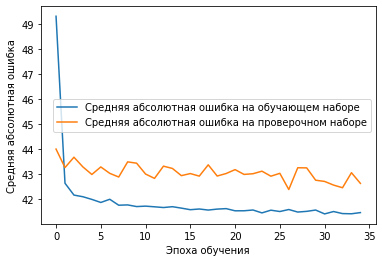

In [29]:
# Вариант №3 Увеличены размеры первых двух слоёв

model = Sequential()
model.add(BatchNormalization(input_dim = x_train_01.shape[1]))
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.25))
model.add(Dense(4096, activation = 'tanh'))
model.add(BatchNormalization())
model.add(Dense(32, activation = 'relu'))
model.add(Dense(1, activation = 'linear'))

model.compile(optimizer = Adam(learning_rate=0.0001), loss = 'mse', metrics = ['mae'])
hist = model.fit(x_train_01, y_train, epochs=35, batch_size = 128, validation_split = 0.15, verbose = 1)
plot_history(hist)

Epoch 1/35
105/105 [==============================] - 11s 96ms/step - loss: 8122.2666 - mae: 59.5144 - val_loss: 11135.6279 - val_mae: 75.7662
Epoch 2/35
105/105 [==============================] - 10s 94ms/step - loss: 5269.9028 - mae: 44.3360 - val_loss: 8686.3994 - val_mae: 60.3458
Epoch 3/35
105/105 [==============================] - 9s 88ms/step - loss: 4823.8413 - mae: 42.7190 - val_loss: 6717.6577 - val_mae: 47.7099
Epoch 4/35
105/105 [==============================] - 10s 95ms/step - loss: 4701.2710 - mae: 42.3136 - val_loss: 5560.8984 - val_mae: 42.5397
Epoch 5/35
105/105 [==============================] - 10s 93ms/step - loss: 4653.2524 - mae: 42.1700 - val_loss: 5084.3330 - val_mae: 42.3491
Epoch 6/35
105/105 [==============================] - 10s 95ms/step - loss: 4624.5469 - mae: 42.0805 - val_loss: 4978.8394 - val_mae: 42.7240
Epoch 7/35
105/105 [==============================] - 10s 93ms/step - loss: 4605.2080 - mae: 42.0307 - val_loss: 4933.5503 - val_mae: 43.1159
Epoch 

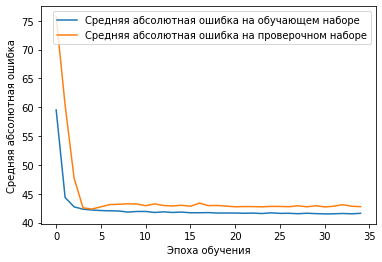

In [30]:
# Вариант №4 Увеличен размер batch_size

model = Sequential()
model.add(BatchNormalization(input_dim = x_train_01.shape[1]))
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.25))
model.add(Dense(4096, activation = 'tanh'))
model.add(BatchNormalization())
model.add(Dense(32, activation = 'relu'))
model.add(Dense(1, activation = 'linear'))

model.compile(optimizer = Adam(learning_rate=0.0001), loss = 'mse', metrics = ['mae'])
hist = model.fit(x_train_01, y_train, epochs=35, batch_size = 512, validation_split = 0.15, verbose = 1)
plot_history(hist)

Epoch 1/35
105/105 [==============================] - 11s 96ms/step - loss: 9661.8857 - mae: 69.0093 - val_loss: 11775.6328 - val_mae: 79.2633
Epoch 2/35
105/105 [==============================] - 10s 94ms/step - loss: 6508.9648 - mae: 51.7333 - val_loss: 9428.1729 - val_mae: 65.6705
Epoch 3/35
105/105 [==============================] - 10s 93ms/step - loss: 5323.3867 - mae: 45.8624 - val_loss: 6984.1250 - val_mae: 50.1488
Epoch 4/35
105/105 [==============================] - 10s 95ms/step - loss: 4928.5620 - mae: 43.6647 - val_loss: 5570.0200 - val_mae: 43.6916
Epoch 5/35
105/105 [==============================] - 9s 88ms/step - loss: 4739.3765 - mae: 42.5991 - val_loss: 5094.9062 - val_mae: 43.0513
Epoch 6/35
105/105 [==============================] - 10s 92ms/step - loss: 4642.9971 - mae: 42.0611 - val_loss: 4949.5889 - val_mae: 43.5222
Epoch 7/35
105/105 [==============================] - 10s 94ms/step - loss: 4602.3062 - mae: 41.9538 - val_loss: 4914.6689 - val_mae: 43.4973
Epoch 

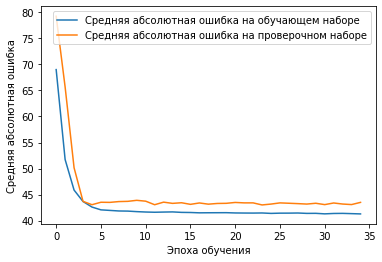

In [31]:
# Вариант №5 Изменена функция активации второго слоя.

model = Sequential()
model.add(BatchNormalization(input_dim = x_train_01.shape[1]))
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.25))
model.add(Dense(4096, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dense(32, activation = 'relu'))
model.add(Dense(1, activation = 'linear'))

model.compile(optimizer = Adam(learning_rate=0.0001), loss = 'mse', metrics = ['mae'])
hist = model.fit(x_train_01, y_train, epochs=35, batch_size = 512, validation_split = 0.15, verbose = 1)
plot_history(hist)

Epoch 1/35
105/105 [==============================] - 23s 206ms/step - loss: 6891.1157 - mae: 52.8458 - val_loss: 10842.5322 - val_mae: 73.7731
Epoch 2/35
105/105 [==============================] - 21s 204ms/step - loss: 4649.3501 - mae: 42.2439 - val_loss: 9039.1592 - val_mae: 62.2927
Epoch 3/35
105/105 [==============================] - 22s 213ms/step - loss: 4583.9863 - mae: 41.8694 - val_loss: 7303.9058 - val_mae: 50.5034
Epoch 4/35
105/105 [==============================] - 26s 247ms/step - loss: 4568.6558 - mae: 41.7672 - val_loss: 5825.2100 - val_mae: 42.6291
Epoch 5/35
105/105 [==============================] - 21s 202ms/step - loss: 4546.4790 - mae: 41.7276 - val_loss: 5124.7134 - val_mae: 41.4727
Epoch 6/35
105/105 [==============================] - 21s 201ms/step - loss: 4541.1108 - mae: 41.6632 - val_loss: 4896.4800 - val_mae: 42.8614
Epoch 7/35
105/105 [==============================] - 21s 205ms/step - loss: 4534.4443 - mae: 41.5904 - val_loss: 4858.9780 - val_mae: 43.881

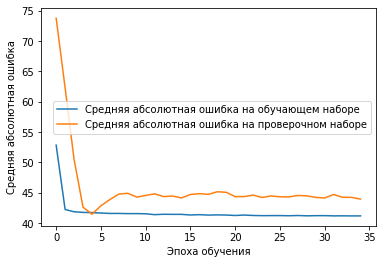

In [33]:
# Вариант №6 Добавлен дополнительный слой.

model = Sequential()
model.add(BatchNormalization(input_dim = x_train_01.shape[1]))
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.25))
model.add(Dense(4096, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dense(512, activation = 'relu'))
model.add(Dense(32, activation = 'relu'))
model.add(Dense(1, activation = 'linear'))

model.compile(optimizer = Adam(learning_rate=0.0001), loss = 'mse', metrics = ['mae'])
hist = model.fit(x_train_01, y_train, epochs=35, batch_size = 512, validation_split = 0.15, verbose = 1)
plot_history(hist)

Вывод: Изменение доступных в задании параметров на результат практически не влияет.